# Advanced Lane Line Detection

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import PIL

%matplotlib inline

## Undisorting the image
Undistortor is a class which stores a camera profile created from the calibration images provided. I create an instance of this class to use throughout the notebook, as it takes a bit to run the calibration. Below is an example of the the undistortion taking place. Only the first image is included, as the others are less demonstrative of the effects. Also included a highway test image, in which you can see that the sign is pulled closer to the right side of the the image after the calibration is applied.

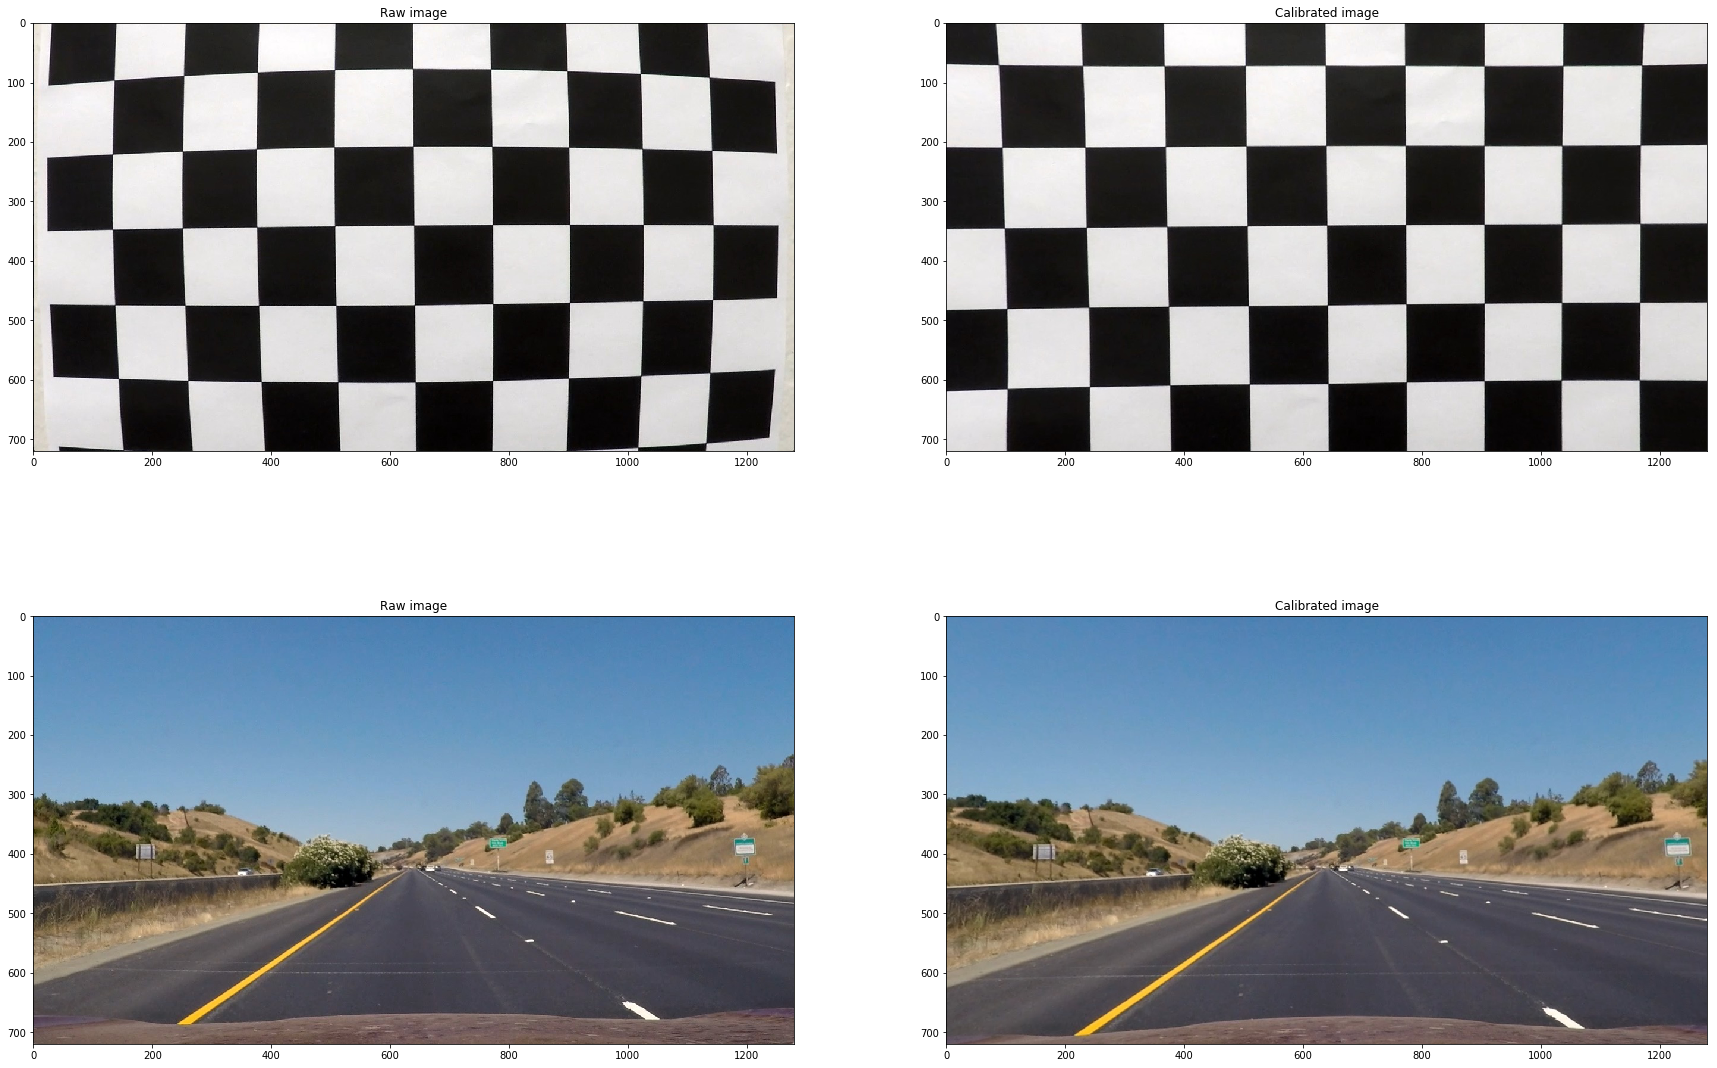

In [2]:
class Undistortor:
    def __init__(self):
        numx, numy = 9, 6
        objp = np.zeros((numx*numy, 3), np.float32)
        objp[:, :2] = np.mgrid[0:numx, 0:numy].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('./camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (numx, numy), None)

            # If found, add object points, image points
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        ret, self.mtx, self.dist, _, _ = cv2.calibrateCamera(
            objpoints, imgpoints, gray.shape[::-1], None, None
        )

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def plot(self):
        images = glob.glob('./camera_cal/calibration1.jpg') + glob.glob('./test_images/straight_lines1.jpg')
        fig, axs = plt.subplots(len(images), 2, figsize=(30,20))
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            ax[0].imshow(img)
            ax[0].set_title('Raw image')
            ax[1].imshow(self.undistort(img))
            ax[1].set_title('Calibrated image')
        plt.show()
        
UNDISTORTOR = Undistortor()
UNDISTORTOR.plot()

## Creating a binary image
To better detect lane lines, different filters are applied to the image, and pixels are extracted which exceed specified thresholds. A few different filters were tried, including various color spaces (red-green-blue, hue-saturation-lightness) and Sobel operators. Combining red and green spaces (yellow) and Sobel X gradients produced good results, seen below. The final filter takes pixels if they appear in either filter.

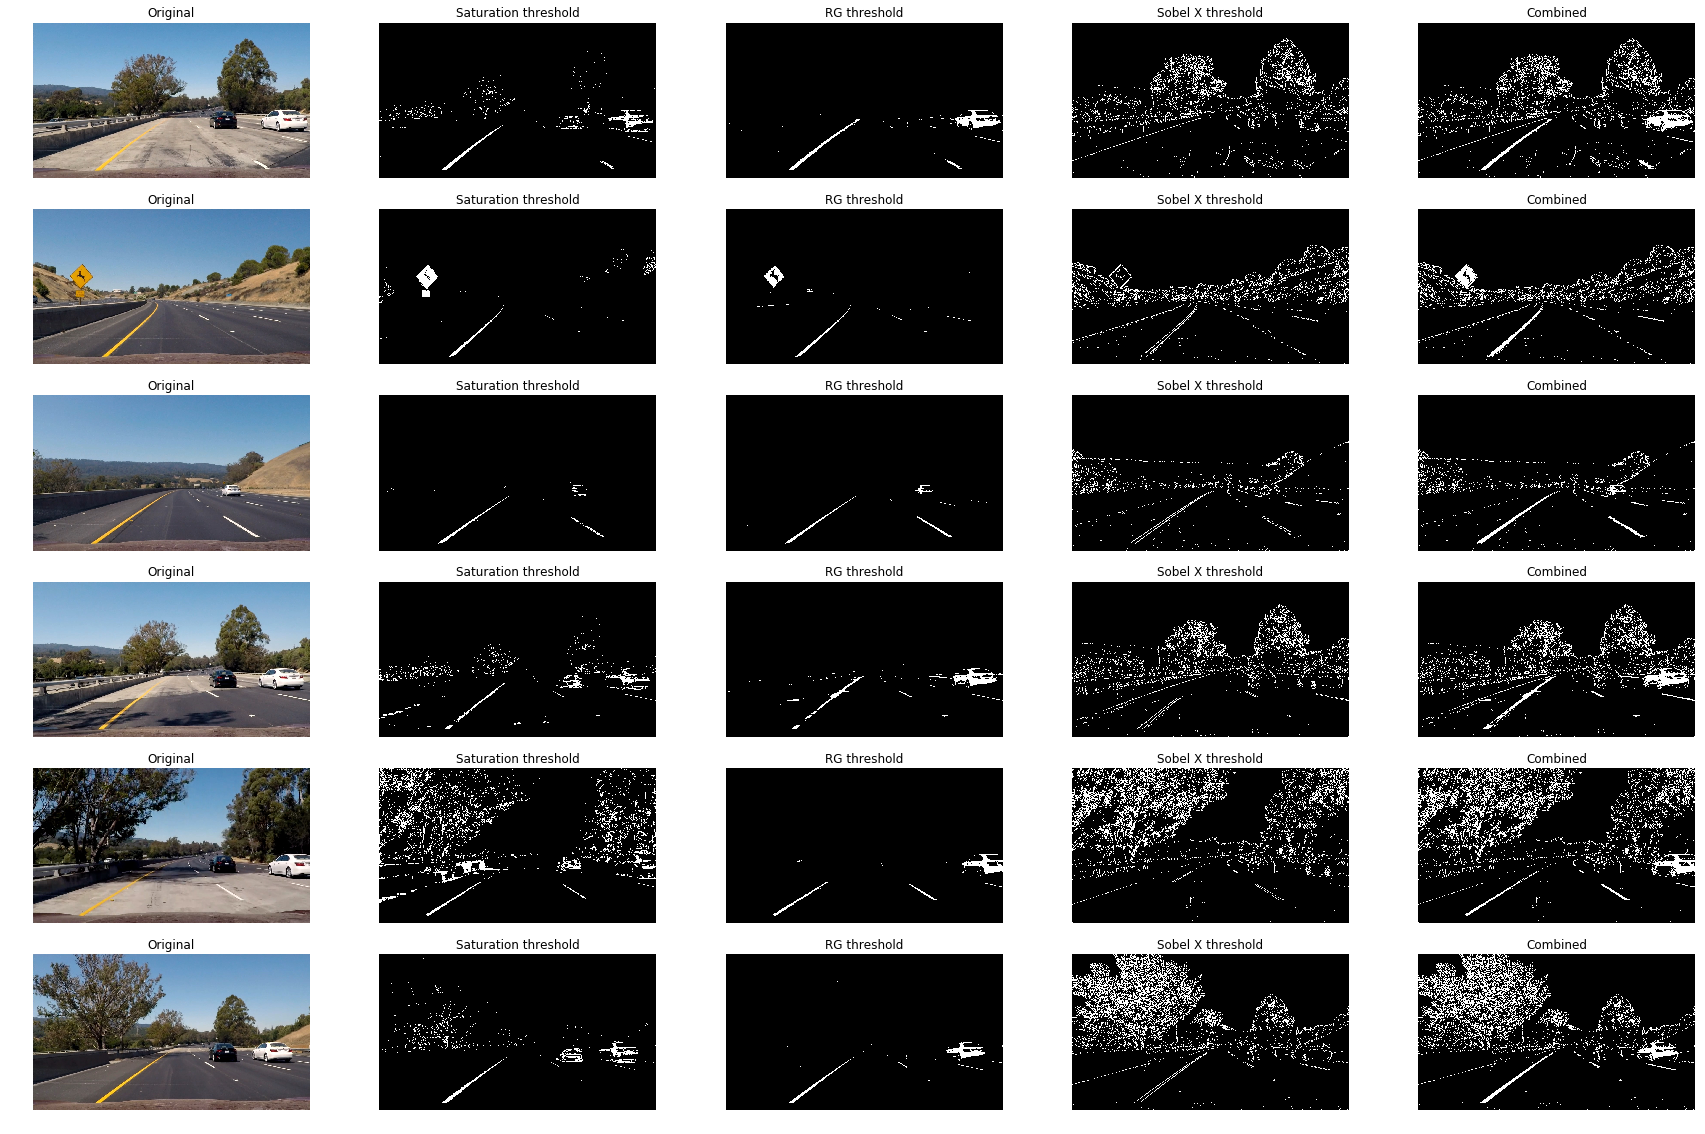

In [3]:
class Binarizor:
    def form_s_binary(self, img):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

        s_channel = hls[:,:,-1]
        
        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        return s_binary
    
    def form_r_binary(self, img):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        s_channel = np.mean(img[:,:,0:1], axis=2)
        
        # Threshold color channel
        s_thresh_min = 220
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        return s_binary
    
    def form_sobelx_binary(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 20
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def dir_threshold(self, img, sobel_kernel=11, thresh=(0, np.pi/8)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(sobely, sobelx)
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(25, 255)):

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output
        
    def binarize(self, img):
        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        sxbinary = self.form_sobelx_binary(img)
        s_binary = self.form_s_binary(img)
        rg_binary = self.form_r_binary(img)
        dir_threshold = self.dir_threshold(img)
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[
            (
                (rg_binary == 1) 
                | (sxbinary == 1)
            )                
#                  & (dir_threshold == 1)
        ] = 1
        return combined_binary

    def ret_img(self, img):
        return img
    
    def plot(self):
        images = glob.glob('./test_images/test*.jpg')
        funcs = [
            (self.ret_img, 'Original'),
            (self.form_s_binary, 'Saturation threshold'),
            (self.form_r_binary, 'RG threshold'),
            (self.form_sobelx_binary, 'Sobel X threshold'),
            #(self.mag_thresh, 'Sobel magnitude threshold),
            #(self.dir_threshold, 'Sobel direction threshold),
            (self.binarize, 'Combined')
        ]
        fig, axs = plt.subplots(6, len(funcs), figsize=(30,20))
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            for idx, func in enumerate(funcs):
                ax[idx].imshow(func[0](img), cmap='gray')
                ax[idx].set_title(func[1])
                ax[idx].axis('off')
        plt.show()
        
Binarizor().plot()

## Transforming the viewpoint
To determine the curvature of the lines, the images were transformed into a viewpoint where straight lines would appear parallel, i.e. looking from overhead. A known rectangular patch, centered on the image was selected and mapped to a true rectangular patch in the warped image. The results of this transform can be seen below.

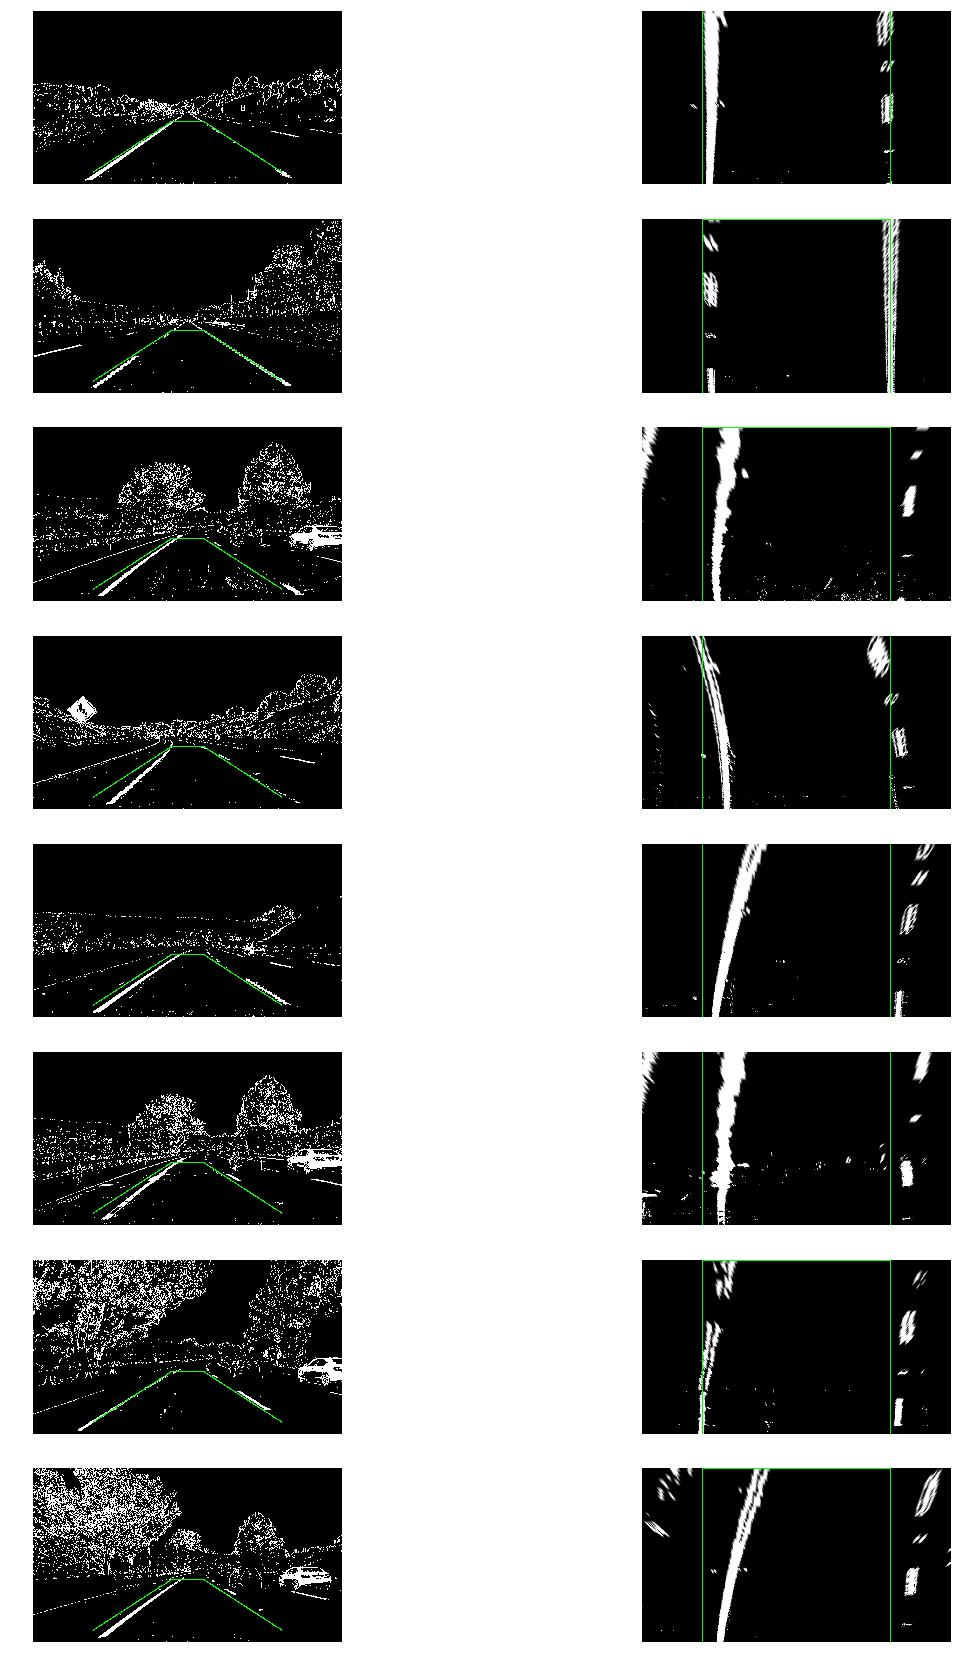

In [4]:
class Warper:
    def __init__(self):
        self.height, self.width = 720, 1280
        x_bot_off = 250
        x_top_off = 575
        y_bot_off = 50
        y_top_off = 460
        self.src = [[x_bot_off, self.height-y_bot_off],
                    [x_top_off, y_top_off], 
                    [self.width-x_top_off, y_top_off], 
                    [self.width-x_bot_off, self.height-y_bot_off]]
        self.dst = [
            [x_bot_off, self.height], 
            [x_bot_off, 0], 
            [self.width-x_bot_off, 0], 
            [self.width-x_bot_off, self.height]
        ]
        self.M = cv2.getPerspectiveTransform(np.float32(self.src), np.float32(self.dst))
        self.Minv = cv2.getPerspectiveTransform(np.float32(self.dst), np.float32(self.src))

    def warp(self, img):
        return cv2.warpPerspective(img, self.M, (self.width, self.height), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, (self.width, self.height), flags=cv2.INTER_LINEAR)
    
    def draw_lines(self, img, lines, color=[0, 255, 0], thickness=3):
        copied = np.copy(img)
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(copied, (x1, y1), (x2, y2), color, thickness)
        return copied
    
    def plot(self):
        images = glob.glob('./test_images/straight*.jpg') + glob.glob('./test_images/test*.jpg')
        fig, axs = plt.subplots(8, 2, figsize=(20,30))
        binarizor = Binarizor()
        line1 = [self.src[0]+self.src[1], self.src[1]+self.src[2], self.src[2]+self.src[3], self.src[3]+self.src[-1]]
        line2 = [self.dst[0]+self.dst[1], self.dst[1]+self.dst[2], self.dst[2]+self.dst[3], self.dst[3]+self.dst[-1]]
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            img = UNDISTORTOR.undistort(img)
            img = binarizor.binarize(img)
            img = img*255
            img = np.dstack(( img, img, img))
            ax[0].imshow(self.draw_lines(img,line1))
            ax[0].axis('off')
            ax[1].imshow(self.draw_lines(self.warp(img),line2))
            ax[1].axis('off')            
        plt.show()
        
Warper().plot()

In [5]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Fitting lines
To find lines in the image, a histogram was created of the bottom half of the image, and windows were places at the peaks in the left and right halves of the image. These windows were the slid upwards, shifting to the median of the cluster of pixels in the previous window, but only if there were more than 100 pixels in that window. A 2nd order polynomial is fit to the pixels that appear in those windows, which then represent the lane lines. These are warped back to the original space using the transformation described above. 

After lane lines are found in the first image, pixels are detected within a margin of the curves found in the previous image. These margins are large at the bottom, then shrink towards the top, to take into account the noise cause by lower resoltion from the projection. This shrinking margin also acts as a kind of filter, as it's more difficult for the curve to be shifted dramatically either direction (the polynomials can only be fit within the margins).

The lane offset and road curvature are calculated as described in the lectures.

/Users/abroekhof/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


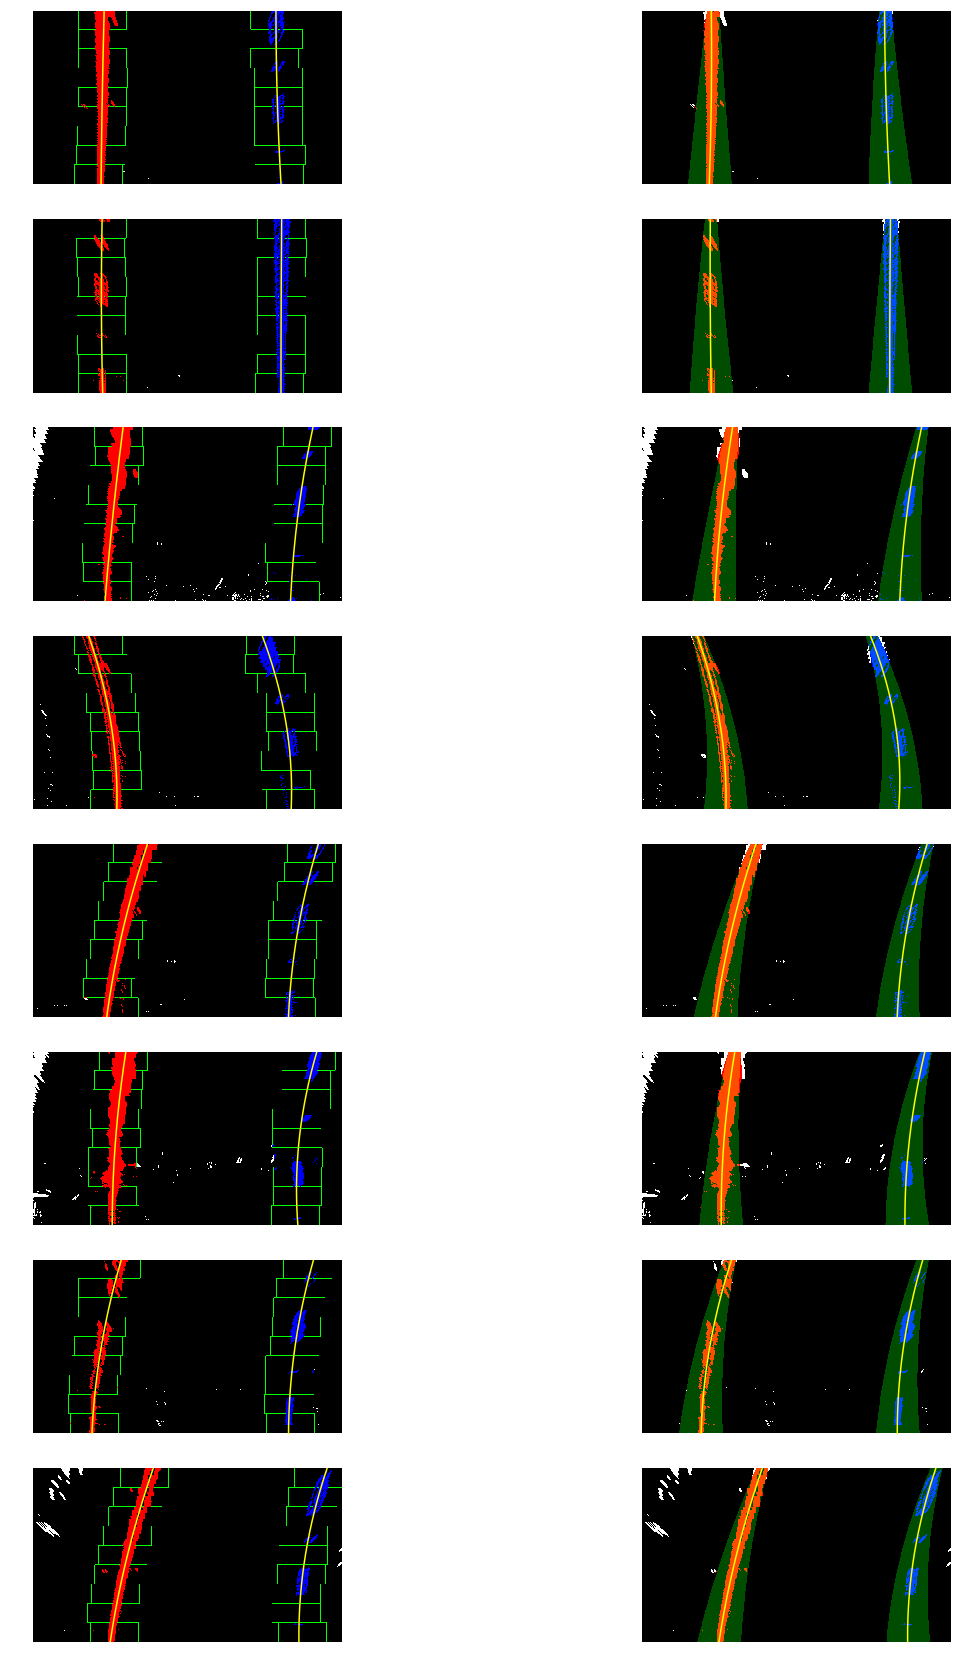

In [6]:
class Fitter:
    def __init__(self, warper):
        # Number of windows
        self.nwindows = 9
        # Minimum number of pixels found to recenter window
        self.minpix = 100
        # Set the width of the windows +/- margin
        self.margin = 100
        
        self.warper = warper
        self.prev_left_line = Line()
        self.prev_right_line = Line()
        
        self.offset = 0
        self.left_curverad = 0
        self.right_curverad = 0
                   
    def fit_first(self, binary_warped):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        windows = []
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & 
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & 
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > self.minpix pixels, recenter next window on their median position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.median(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.median(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        return nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img
    
    def fit_existing(self, binary_warped):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_fit = self.prev_left_line.current_fit
        right_fit = self.prev_right_line.current_fit
        
        # Shrink the margins as the lane line gets farther away.
        cone = (np.linspace(self.margin/4, self.margin-10, nonzeroy.shape[0]))
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - cone)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + cone))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - cone)) &
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + cone)))  
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        cone = (np.linspace(self.margin/4, self.margin-10, ploty.shape[0]))
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-cone, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+cone, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-cone, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+cone, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return nonzerox, nonzeroy, left_lane_inds, right_lane_inds, result
    
    def fit_points(self, binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
        # Fit a second order polynomial to each
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        self.prev_left_line.current_fit = left_fit
        self.prev_left_line.detected = True
        self.prev_right_line.current_fit = right_fit
        self.prev_right_line.detected = True
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Calculate lane offset
        lane_width = right_fitx[-1] - left_fitx[-1]
        lane_center = (lane_width/2) + left_fitx[-1]
        self.offset = (binary_warped.shape[1]/2 - lane_center)/lane_width*3.7
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_fitx, right_fitx, ploty
    
    def form_result(self, binary_warped, orig, left_fitx, right_fitx, ploty):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = self.warper.unwarp(color_warp) 
        # Combine the result with the original image
        result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)

        return result

    def fit(self, binary_warped, orig):
        if self.prev_left_line.detected and self.prev_right_line.detected:
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds, _ = self.fit_existing(binary_warped)
        else:
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds, _ = self.fit_first(binary_warped)
        left_fitx, right_fitx, ploty =  self.fit_points(
            binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
        return self.form_result(binary_warped, orig, left_fitx, right_fitx, ploty)
    
    def plot(self):
        images = glob.glob('./test_images/straight*.jpg') + glob.glob('./test_images/test*.jpg')
        fig, axs = plt.subplots(len(images), 2, figsize=(20,30))
        binarizor = Binarizor()
        for idx, ax in enumerate(axs):
            orig = mpimg.imread(images[idx])
            img = UNDISTORTOR.undistort(orig)
            img = binarizor.binarize(img)
            img = self.warper.warp(img)
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img = self.fit_first(img)
            left_fitx, right_fitx, ploty=self.fit_points(img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
            ax[0].imshow(out_img)
            ax[0].plot(left_fitx, ploty, color='yellow')
            ax[0].plot(right_fitx, ploty, color='yellow')
            ax[0].set_xlim(0, 1280)
            ax[0].set_ylim(720, 0)
            ax[0].axis('off')
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img = self.fit_existing(img)
            left_fitx, right_fitx, ploty = self.fit_points(img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
            ax[1].imshow(out_img)
            ax[1].plot(left_fitx, ploty, color='yellow')
            ax[1].plot(right_fitx, ploty, color='yellow')
            ax[1].set_xlim(0, 1280)
            ax[1].set_ylim(720, 0)
            ax[1].axis('off')
        plt.show()
        
Fitter(Warper()).plot()

## Pipeline
The pipeline assembles all above steps into a single function and applies it to images. It also adds text of the lane offset and road curvature.

In [7]:
class Pipeline:
    def __init__(self):
        # Use pre-allocated undistortor so you we don't need to recalculate the weights.
        self.undistortor = UNDISTORTOR
        self.binarizor = Binarizor()
        self.warper = Warper()
        self.fitter = Fitter(self.warper)
        
    def run(self, img):
        undist = self.undistortor.undistort(img)
        combined_binary = self.binarizor.binarize(undist)
        binary_warped = self.warper.warp(combined_binary)
        fitted = self.fitter.fit(binary_warped, img)
        img = PIL.Image.fromarray(fitted, mode='RGB')
        draw = ImageDraw.Draw(img)
#         font = ImageFont.truetype("/usr/share/fonts/truetype/droid/DroidSans.ttf", 56)
        font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 56)        
        draw.text((0, 0),"Lane offset: {0:.2f} m\nLeft radius: {1:.2f} m\nRight radius: {2:.2f} m".format(
            self.fitter.offset,
            self.fitter.left_curverad, 
            self.fitter.right_curverad),(255,255,255),font=font)
        return np.array(img)

/Users/abroekhof/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


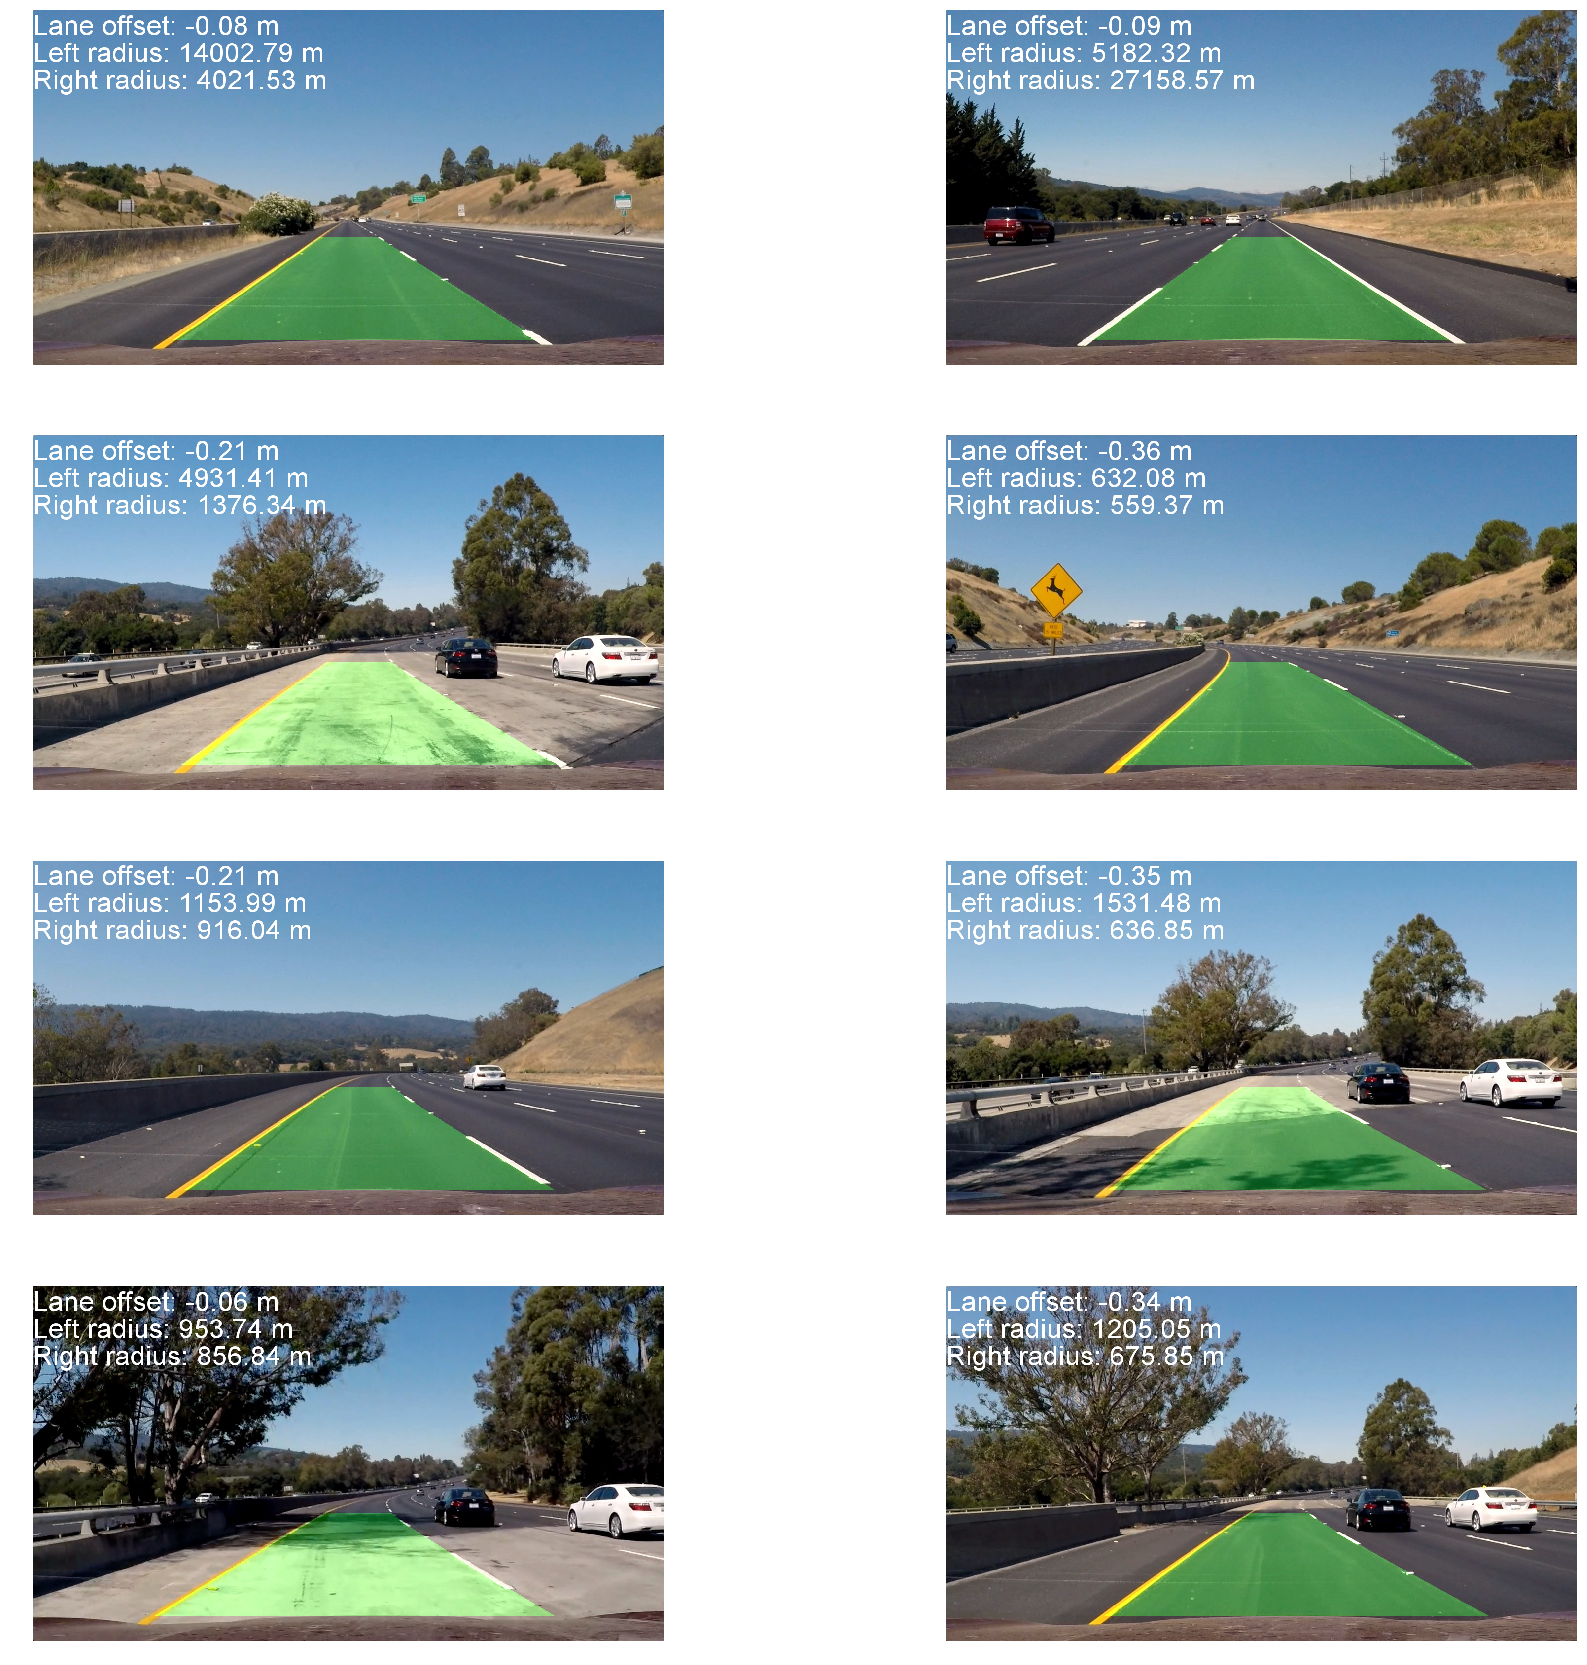

In [8]:
images = glob.glob('./test_images/straight*.jpg') + glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(30,30))
cnt = 0
for ax in axs:
    for x in ax:
        img = mpimg.imread(images[cnt])
        # Create a new pipeline each time so that the sliding window method is used.
        pipeline = Pipeline()
        img = pipeline.run(img)
        x.imshow(img)
        x.axis('off')
        cnt += 1
plt.show()

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline = Pipeline()

white_output = './fitted.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline.run)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./fitted.mp4
[MoviePy] Writing video ./fitted.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./fitted.mp4 

CPU times: user 4min 55s, sys: 56.2 s, total: 5min 51s
Wall time: 4min 58s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))